<h1 align="left"> Santader Product Recommendation</h1>

In [8]:
from IPython.display import Image

<img src="Images/1.jpeg" width="740" height="740" align="center"/>

## Problem Statement

Santander is a banking company in Spain that offers an array of financial products. Their current system was flawed in that a small number of their customers would receive many recommendations while many others would not see any at all. Santander tasked kaggle competitors to accurately predict what their existing customers would use in the next month.

We are given a train dataset with more than 13MM records containing information about 950,000 customers. It contains 1.5 years (17 month) of customers behavior data beginning from Jan 2015 to May 2016 from Santander bank to predict what new products customers will purchase. We are asked to recommend products for customers in June 2016. The train dataset contains 48 columns. The first set of 24 columns are different features about the customers, such as when the customer joined, whether the customer’s spouse is working for the bank, customer’s age, where he lives etc. The second set of 24 columns are the products such as current_account, savings_account, payroll_account etc, that the customer holds as of that date. 

<b>Note:</b> The column names are in Spanish. For EDA, I have converted the Spanish named columns to English columns.

Submissions are evaluated according to the Mean Average Precision @ 7 (MAP@7):

<img src="Images/MAP.png" width="440" height="300" align="center"/>

where |U| is the number of rows (users in two time points), P(k) is the precision at cutoff k, n is the number of predicted products, and m is the number of added products for the given user at that time point. If m = 0, the precision is defined to be 0.

### Submission File

For every user at each time point, you must predict a space-delimited list of the products they added. The file should contain a header and have the following format:

<b>ncodpers</b>, <b>added_products</b> <br>
15889,ind_tjcr_fin_ult1 <br>
15890,ind_tjcr_fin_ult1 ind_recibo_ult1 <br>
15892,ind_nomina_ult1 <br>
15893, <br>
etc.

**Dataset:**

| Index | Column Name | Description |
| - | ---| ---|
| 1| fecha_dato | The table is partitioned for this column |
| 2| ncodepers | Customer code |
| 3| ind_empleado | Employee index : A active, B ex employed, F filial, N not employee, P pasive |
| 4| pais_residencia | Customer's Country residence |
| 5| sexo | Customer's sex |
| 6| age | Age |
| 7| fecha_alta | The date in which the customer became as the first holder of a contract in the bank |
| 8| ind_nuevo | New customer Index: 1 if the customer registered in the last 6 months |
| 9| antiguedad | Customer seniority (in months) |
| 10| indrel | 1 (First/Primary), 99 (Primary customer during the month but not at the end of the month)|
| 11| ult_fec_cli_1t | Last date as primary customer (if he isn't at the end of the month) |
| 12| indrel_1mes | Customer type at the begining of the month ,1 (First/Primary customer), 2 (co-owner ),P (Potential),3 (former primary), 4(former co-owner) |
| 13|tiprel_1mes	 |  Customer relation type at the beginning of the month, A (active), I (inactive), P (former customer),R (Potential) |
| 14|indresi | Residence index (S (Yes) or N (No) if the residence country is the same than the bank country) |
| 15|indext | Foreigner index (S (Yes) or N (No) if the customer's birth country is different than the bank country) |
| 16|conyuemp | Spouse index. 1 if the customer is spouse of an employee |
| 17|canal_entrada | Channel used by the customer to join |
| 18|indfall| Deceased index. N/S|
| 19|tipodom |  Addres type. 1, primary address |
| 20|cod_prov | Province code (customer's address) |
| 21|nomprov | Province name |
| 22|ind_actividad_cliente | Activity index (1, active customer; 0, inactive customer) |
| 23|renta | Gross income of the household |
| 24|segmento | segmentation: 01 - VIP, 02 - Individuals 03 - college graduated |
| 25-48|25 - 48 | Banking products |

## Modeling

XGBoost is used for this multi classification problem. A single XGBoost model is trained using a target variable which denote the product that is added. For customers that added multiple products, a single one was chosen at random as the target.

## Running Code

In [1]:
# !ls -lha kaggle.json
# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [2]:
import kaggle

In [3]:
!kaggle competitions download -c santander-product-recommendation

 73% 9.00M/12.4M [00:00<00:00, 31.7MB/s]
100% 12.4M/12.4M [00:00<00:00, 35.6MB/s]
  0% 0.00/2.28M [00:00<?, ?B/s]
100% 2.28M/2.28M [00:00<00:00, 124MB/s]
 94% 201M/214M [00:01<00:00, 134MB/s]
100% 214M/214M [00:01<00:00, 134MB/s]


In [4]:
!unzip /content/train_ver2.csv.zip
!unzip /content/test_ver2.csv.zip

Archive:  /content/train_ver2.csv.zip
  inflating: train_ver2.csv          
Archive:  /content/test_ver2.csv.zip
  inflating: test_ver2.csv           


In [11]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")
import csv
import datetime
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

In [12]:
# Load sample data set - 7 million rows for visualization
df_train_sample = pd.read_csv('train_ver2.csv',
                              dtype={"sexo":str, "ind_nuevo":str, 
                                      "ult_fec_cli_1t":str, 
                                      "indext":str}, nrows=7e6)

In [13]:
# Data preprocessing
columns_name = list(df_train_sample.columns[:24])
objs = [preprocessing.LabelEncoder() for i in range(24)]
for index, (col, obj) in enumerate(zip(columns_name, objs)):
  mylist = list(df_train_sample[col].unique())
  mylist = ["0" if  pd.isna(x) else x for x in mylist]
  obj.fit(mylist)

In [14]:
# ETL & Visualization
class Visualizatin():
    def __init__(self,df):
      self.df_train_sample = df
      self.df_train_sample.Age = pd.to_numeric(self.df_train_sample.Age, errors = 'coerce')
      self.df_train_sample.Cust_Since = pd.to_numeric(self.df_train_sample.Cust_Since, errors = 'coerce')
      self.df_train_sample.Cust_Type_Mth_Beg = pd.to_numeric(self.df_train_sample.Cust_Type_Mth_Beg, errors = 'coerce')

    def  df_check_info(self):
      print(self.df_train_sample.info())
    def calculate_null(self):
      print(self.df_train_sample.isnull().sum())
    def age_distribution(self):
      plt.figure(figsize=(10,6))
      sns.distplot(self.df_train_sample["Age"].dropna(),bins=50, color="r")
      plt.title("Age Distribution")
      plt.xlabel("Age", fontsize = 13)
      plt.ylabel("Count", fontsize = 13)

    def age_distribution_pp(self):
      self.df_train_sample.loc[self.df_train_sample.Age < 18,"Age"]  = self.df_train_sample.loc[(self.df_train_sample.Age >= 18) & (self.df_train_sample.Age <= 30),"Age"].mean(skipna=True)
      self.df_train_sample.loc[self.df_train_sample.Age > 100,"Age"] = self.df_train_sample.loc[(self.df_train_sample.Age >= 30) & (self.df_train_sample.Age <= 100),"Age"].mean(skipna=True)
      self.df_train_sample["Age"].fillna(self.df_train_sample["Age"].mean(),inplace=True)
      self.df_train_sample["Age"] = self.df_train_sample["Age"].astype(int)
      plt.figure(figsize=(10,6))
      sns.distplot(self.df_train_sample["Age"].dropna(),bins=50, color="r")
      plt.title("Age Distribution")
      plt.xlabel("Age", fontsize = 13)
      plt.ylabel("Count", fontsize = 13)
    def visual_category(self):
      self.df_train_sample.loc[self.df_train_sample.Emp_Status.isnull(), "Emp_Status"] = "N"

      cols = ["Emp_Status","Cust_Ctry","Cust_Sex","Is_New_Cust","Relship_Status","Cust_Type_Mth_Beg","Cust_Relship_Type_Mth_Beg","Residence_Ctry","Is_Foreigner","Join_Channel","Deceased_Flg","Address_Type","Cust_Province_Cd","Cust_Province_Name","Cust_Active_Status","Cust_Segment"]
      for col in cols:
          df_sample = self.df_train_sample.fillna('NA')
          len_unique = len(df_sample[col].unique())
          print("Number of unique values in ",col," : ",len_unique)
          if len_unique < 200:
              agg_df = df_sample[col].value_counts()
              plt.figure(figsize=(12,6))
              sns.barplot(agg_df.index, agg_df.values, alpha=0.8, palette="hsv")
              plt.xlabel(col, fontsize=12)
              plt.ylabel('Number of customers', fontsize=12)
              plt.xticks(rotation='vertical')
              plt.show()
          print()

    def vis_customer(self):
      number_occur = self.df_train_sample.groupby('Cust_ID').size().value_counts()
      plt.figure(figsize=(10,5))
      sns.barplot(number_occur.index, number_occur.values, palette="hsv")
      plt.xlabel('Months', fontsize = 13)
      plt.ylabel('Number of Occurence of Customer', fontsize = 13)
      plt.show()
        
    def product_vis(self):
      target_counts = self.df_train_sample[self.df_train_sample.columns[22:49]].sum(axis=0)
      #print(target_counts)
      plt.figure(figsize=(8,4))
      sns.barplot(target_counts.index, target_counts.values, alpha=0.8, palette="hsv")
      plt.xlabel('Product Name', fontsize=12)
      plt.ylabel('Number of Occurrences', fontsize=12)
      plt.xticks(rotation='vertical')
      plt.show()
        
    def gross_income(self):
      unique_values = np.sort(self.df_train_sample.Gross_HHLD_Income.unique())
      plt.scatter(range(len(unique_values)), unique_values)
      plt.show()
    
    def distribution_product_age(self):
      fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10,15))
      plt.subplots_adjust(wspace=1.3, hspace=0.6)
      fig_row=0
      for col_id in range(24, 46):
          ax_id=col_id-24
          fig_label=self.df_train_sample.columns[col_id]
          feat=self.df_train_sample.columns[col_id]
          fig_col=(col_id+1)%5
          box_plot=sns.boxplot(y='Age', data=self.df_train_sample[(self.df_train_sample[feat]==1) & self.df_train_sample.Age], ax=axes[fig_row][fig_col],linewidth=2.5,palette="YlOrRd")
          box_plot.set(xlabel=fig_label)
          if fig_col==4: fig_row+=1
            
    def distribution_product_since(self):
      fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10,15))
      plt.subplots_adjust(wspace=1.3, hspace=0.6)
      fig_row=0
      for col_id in range(24, 46):
          ax_id=col_id-24
          fig_label=self.df_train_sample.columns[col_id]
          feat=self.df_train_sample.columns[col_id]
          fig_col=(col_id+1)%5
          box_plot=sns.boxplot(y='Cust_Since', data=self.df_train_sample[(self.df_train_sample[feat]==1) & self.df_train_sample.Cust_Since], ax=axes[fig_row][fig_col],linewidth=2.5, palette="YlOrRd")
          box_plot.set(xlabel=fig_label)
          if fig_col==3: fig_row+=1

    def distribution_product_province(self):
      fig, axes = plt.subplots(nrows=8, ncols=3, figsize=(9,18))
      plt.subplots_adjust(wspace=0.4, hspace=0.6)
      fig_row=0
      for col_id in range(24, 46):
          ax_id=col_id-24
          fig_label= self.df_train_sample.columns[col_id]
          feat=self.df_train_sample.columns[col_id]
          fig_col=col_id%3
          sns.distplot(self.df_train_sample.Cust_Province_Cd[(self.df_train_sample[feat]==1) & self.df_train_sample['Cust_Province_Cd']], kde=False, 
                      axlabel=fig_label, ax=axes[fig_row][fig_col])
          if fig_col==2: fig_row+=1
                
    def distribution_product_sex(self):
      fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(8,14))
      plt.subplots_adjust(wspace=0.8, hspace=0.5)
      # fig.tight_layout()
      fig_row=0
      for col_id in range(24, 46):
          ax_id=col_id-24
          fig_label= self.df_train_sample.columns[col_id]
          feat=self.df_train_sample.columns[col_id]
          fig_col=(col_id)%4
          countplot=sns.countplot(x='Cust_Sex', data=self.df_train_sample[(self.df_train_sample[feat]==1) & (self.df_train_sample['Cust_Sex'].notna())],ax=axes[fig_row][fig_col])
          countplot.set(xlabel=fig_label)
          if fig_col==3: fig_row+=1
                
    def customers_data_monthly(self):
      self.df_train_sample["Status_Dt"] = pd.to_datetime(self.df_train_sample["Status_Dt"],format="%Y-%m-%d")
      status_year_month = self.df_train_sample['Status_Dt'].apply(lambda x: (100*x.year) + x.month)
      cnt_status_year_month = status_year_month.value_counts()
      plt.figure(figsize=(10,6))
      sns.barplot(cnt_status_year_month.index, cnt_status_year_month.values, alpha=0.8, palette="hsv")
      plt.xticks(rotation=75)
      plt.title('Customers data on a monthly basis')
      plt.xlabel('Frequency')
      plt.ylabel('Year and Month of Observation')
    
    def number_customers_train(self):
      num_cust_ids =  self.df_train_sample.groupby(['Cust_ID']).agg('size').value_counts()
      plt.figure(figsize=(10,6))
      sns.barplot(num_cust_ids.index, num_cust_ids.values, alpha=0.8, palette="hsv")
      plt.xticks(rotation=75)
      plt.title('Number of customers in the train set')
      plt.xlabel('Frequency')
      plt.ylabel('Number of customers')
    
    def number_employees(self):
      emp_status =  self.df_train_sample.Emp_Status.value_counts()
      len_unique = len(emp_status)
      print("Number of unique values in Employee Status : ", len_unique)
      plt.figure(figsize=(10,6))
      plt.ticklabel_format(style = 'plain')
      sns.barplot(emp_status.index, emp_status.values, alpha=0.8, palette="hsv")
      plt.title('Employee Status')
      plt.xlabel('Employee Status')
      plt.ylabel('Number of Employees')
    
    def number_employees_log(self):
      emp_status =  self.df_train_sample.Emp_Status.value_counts()
      len_unique = len(emp_status)
      print("Number of unique values in Employee Status : ", len_unique)
      plt.figure(figsize=(10,6))
      sns.barplot(emp_status.index, np.log1p(emp_status.values), alpha=0.8, palette="hsv")
      plt.title('Employee Status')
      plt.xlabel('Employee Status')
      plt.ylabel('Number of Employees-Log')
        
    def customer_residence(self):
      cust_country =  self.df_train_sample['Cust_Ctry'].value_counts()
      len_unique = len(cust_country)
      print("Number of unique values in Cusotmer Country : ", len_unique)
      plt.figure(figsize=(30,6))
      sns.barplot(cust_country.index, np.log1p(cust_country.values), alpha=0.8, palette="hsv")
      plt.title('Customer\'s Country of Residence')
      plt.xlabel('Customer\'s Country')
      plt.ylabel('Number of Employees')
        
    def customer_age(self):
      cust_age =  self.df_train_sample['Age'].value_counts()
      len_unique = len(cust_age)
      print("Number of unique values in Customer Age : ",len_unique)
      print("Most aged Customer is : ", np.max(self.df_train_sample.Age))
      print("Junior most customer is : ", np.min(self.df_train_sample.Age))
      print("Average age of customer is : ", np.mean(self.df_train_sample.Age))
      plt.figure(figsize=(30,6))
      sns.barplot(cust_age.index, cust_age.values, alpha=0.8, palette="hsv")
      plt.title('Customer\'s Age')
      plt.xlabel('Customer\'s Age')
      plt.ylabel('Number of Employees')
    
    def join_month(self):
      self.df_train_sample["Join_Dt"] = pd.to_datetime(self.df_train_sample["Join_Dt"],format="%Y-%m-%d")
      join_month =  self.df_train_sample['Join_Dt'].dt.month.value_counts()
      len_unique = len(join_month)
      print("Number of unique months in Customer\'s Joined Date : ",len_unique)
      print("Most Customer\'s joined in the month of  : ", join_month.index[0])
      print("Few Customer\'s joined in the month of : ", join_month.index[11])
      plt.figure(figsize=(10,6))
      sns.barplot(join_month.index, join_month.values, alpha=0.8, palette="hsv")
      plt.title('Customer\'s Joining Months ')
      plt.xlabel('Months')
      plt.ylabel('Number of Employees')
    
    def new_customers_join(self):
      join_year_month =  self.df_train_sample['Join_Dt'].apply(lambda x: (100*x.year) + x.month)
      cnt_join_year_month = join_year_month.value_counts()
      print("Minimum value of Join Date : ", min(cnt_join_year_month.index))
      print("Maximum value of Join Date : ", max(cnt_join_year_month.index))
      plt.figure(figsize=(12,4))
      sns.barplot(cnt_join_year_month.index, cnt_join_year_month.values, alpha=0.8, palette="hsv")
      plt.xlabel('Year and month of joining', fontsize=12)
      plt.ylabel('Number of customers', fontsize=12)
      plt.xticks(rotation='vertical')
      plt.show()

    def customer_Since(self):
      customer_since =  self.df_train_sample['Cust_Since'].value_counts()
      len_unique = len(customer_since.unique())
      print("Number of unique values in Customer_Since : ",len_unique)
      print("Most number of people have been a customer for the past {} months".format(customer_since.index[0]))
      plt.figure(figsize=(10,6))
      sns.barplot(customer_since.index, np.log1p(customer_since.values), alpha=0.8, palette="hsv")
      plt.title('Customer Since (in months)')
      plt.xlabel('Customers')
      plt.ylabel('Months')

    def channels_used_to_join (self):
      join_channel =  self.df_train_sample.Join_Channel.value_counts()
      len_unique = len(join_channel.unique())
      print("Number of unique values in Channels used to join : ", len_unique)
      sorted_distb = np.argsort(-join_channel.values)
      for i in sorted_distb:
          print('Number of data points in Channel', str(join_channel.index[i]), ':', join_channel.values[i], '(', np.round((join_channel.values[i]/self.df_train_sample.shape[0]*100), 3), '%)')
      plt.figure(figsize=(10,6))
      sns.barplot(join_channel.index, np.log1p(join_channel.values), alpha=0.8, palette="hsv")
      plt.title('Channels used to join')
      plt.xlabel('Channels')
      plt.ylabel('Customers')
    
    def household_distribution(self):
      quantile_series =  self.df_train_sample.Gross_HHLD_Income.quantile(np.arange(0.99,1,0.001))
      plt.figure(figsize=(12,4))
      sns.barplot((quantile_series.index*100), quantile_series.values, alpha=0.8, palette="hsv")
      plt.ylabel('Household income', fontsize=12)
      plt.xlabel('Quantiles', fontsize=12)
      plt.xticks(rotation='vertical')
      plt.show()
    
    def popular_product(self):
      target_variables = list(self.df_train_sample.columns[24:])
      target_counts =  self.df_train_sample[target_variables].astype('float64').sum(axis=0)
      plt.figure(figsize=(15,4))
      sns.barplot(target_counts.index, target_counts.values, alpha=0.8, palette="hsv")
      plt.xlabel('Product Name', fontsize=12)
      plt.ylabel('Number of Customers bought product', fontsize=12)
      plt.ticklabel_format(style = 'plain', axis='y')
      plt.xticks(rotation='vertical')
      plt.show()
    
    def popularity_of_products_by_sex(self):
      df_a =  self.df_train_sample.loc[:, ['Cust_Sex', 'Cust_Active_Status']].join(self.df_train_sample.loc[:, "Savings_Acct": "Direct_Debit"])
      df_a = df_a.groupby(['Cust_Sex', 'Cust_Active_Status']).sum()
      df_a = df_a.T
      df_a.head()
      df_a.plot(kind='barh', fontsize=14, figsize=[16,12], colormap='autumn_r', width=1)
      plt.title('Popularity of products by sex and activity index', fontsize=20) 
      plt.xlabel('Number of customers', fontsize=17) 
      plt.ylabel('Products_names', fontsize=17) 
      plt.legend(["Sex:H; Activity_Ind:0(Inactive)", "Sex:H; Activity_Ind:1(Active)", "Sex:V; Activity_Ind:0(Inactive)", 
                  "Sex:V; Activity_Ind:1(Active)"], prop={'size':15}) 
    
    def popularity_of_products_by_sex_exclude(self):
      """
      Observation: As noted earlier the most popular product is Cur_Acct.<br>
      Lets exclude the dominant product and analyze others.
      """
      df_a =  self.df_train_sample.loc[:, ['Cust_Sex', 'Cust_Active_Status']].join( self.df_train_sample.loc[:, "Savings_Acct": "Direct_Debit"])
      df_a = df_a.groupby(['Cust_Sex', 'Cust_Active_Status']).sum()
      exclude = ['Cur_Acct']
      df_a = df_a.drop(exclude, axis=1).T
      df_a.plot(kind='barh', fontsize=14, figsize=[16,20], width=1.5, colormap='autumn_r')
      plt.title('Popularity of products by sex and activity index', fontsize=20) 
      plt.xlabel('Number of customers', fontsize=17) 
      plt.ylabel('Products_names', fontsize=17) 
      plt.legend(["Sex:H; Activity_Ind:0(Inactive)", "Sex:H; Activity_Ind:1(Active)", "Sex:V; Activity_Ind:0(Inactive)", 
                  "Sex:V; Activity_Ind:1(Active)"], prop={'size':15}) 

In [15]:
# Select a sample from data set for EDA & Visualization
n = 500000
unique_ids = pd.Series(df_train_sample["ncodpers"].unique())
unique_id = unique_ids.sample(n)
df_train_sample = df_train_sample[df_train_sample.ncodpers.isin(unique_id)]

In [16]:
# Translate column names from Spanish to English for EDA & visualization
df_train_sample.columns = ['Status_Dt', 'Cust_ID', 'Emp_Status', 'Cust_Ctry', 'Cust_Sex', 'Age', 'Join_Dt',
                  'Is_New_Cust', 'Cust_Since', 'Relship_Status','Lst_Dt_Primary_Cust', 'Cust_Type_Mth_Beg', 
                  'Cust_Relship_Type_Mth_Beg', 'Residence_Ctry', 'Is_Foreigner', 'Is_Spouse_Emp', 'Join_Channel', 'Deceased_Flg', 
                  'Address_Type', 'Cust_Province_Cd', 'Cust_Province_Name', 'Cust_Active_Status', 'Gross_HHLD_Income',
                  'Cust_Segment', 'Savings_Acct', 'Guarantees', 'Cur_Acct', 'Derivative_Acct', 'Payroll_Acct',
                  'Junior_Acct', 'Mas_Particular_Acct', 'Particular_Acct', 'Particular_Plus_Acct', 'Short_Term_Deposits',
                  'Med_Term_Deposits', 'Long_Term_Deposits', 'e-Acct', 'Funds', 'Mortgage', 'Pension1', 'Loans',
                  'Taxes', 'Credit_Card', 'Securities', 'Home_Acct', 'Payroll', 'Pension2', 'Direct_Debit'] 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3871130 entries, 0 to 6999998
Data columns (total 48 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Status_Dt                  object 
 1   Cust_ID                    int64  
 2   Emp_Status                 object 
 3   Cust_Ctry                  object 
 4   Cust_Sex                   object 
 5   Age                        float64
 6   Join_Dt                    object 
 7   Is_New_Cust                object 
 8   Cust_Since                 float64
 9   Relship_Status             float64
 10  Lst_Dt_Primary_Cust        object 
 11  Cust_Type_Mth_Beg          float64
 12  Cust_Relship_Type_Mth_Beg  object 
 13  Residence_Ctry             object 
 14  Is_Foreigner               object 
 15  Is_Spouse_Emp              object 
 16  Join_Channel               object 
 17  Deceased_Flg               object 
 18  Address_Type               float64
 19  Cust_Province_Cd           float64
 20  Cu

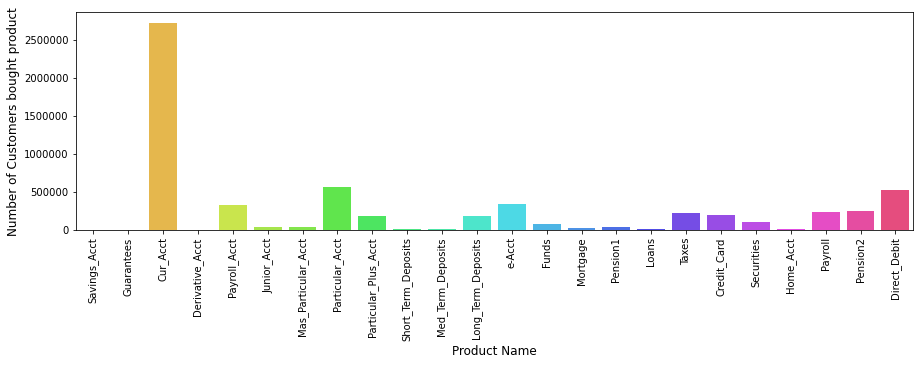

Number of unique values in  Emp_Status  :  5


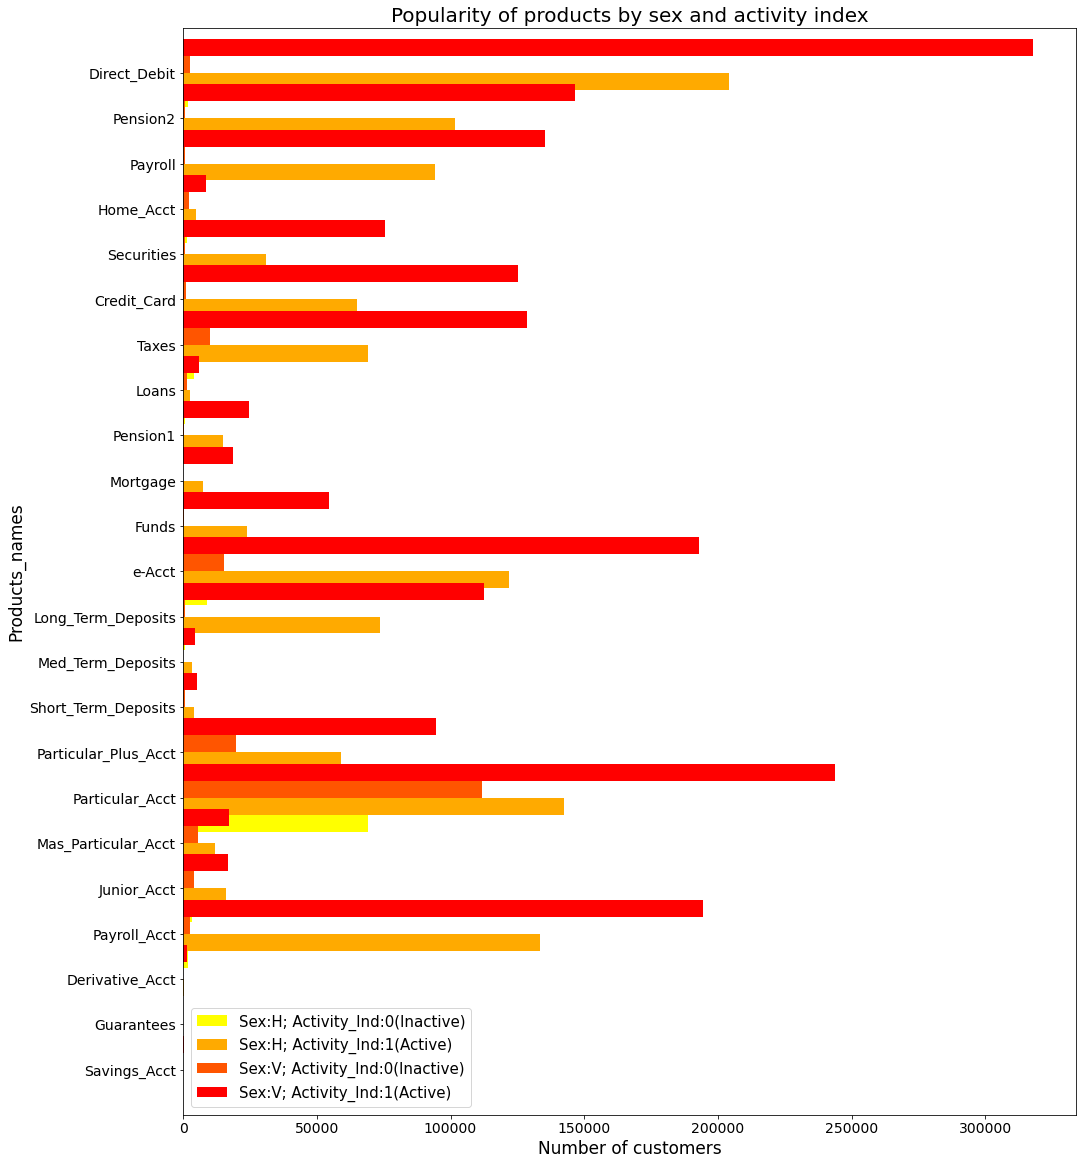

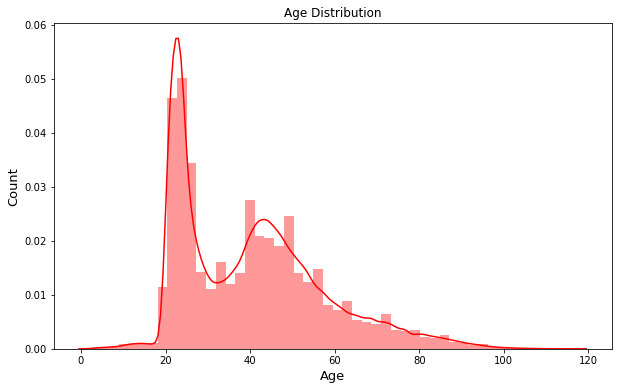

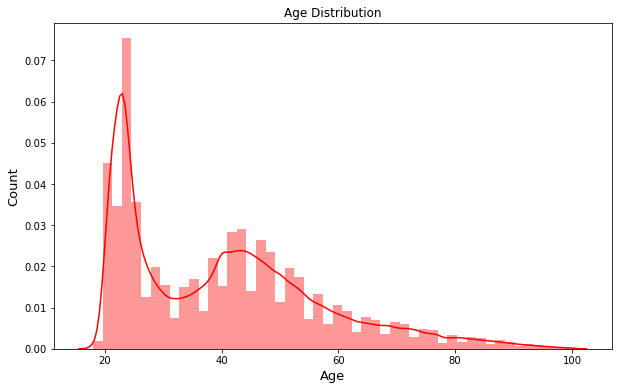

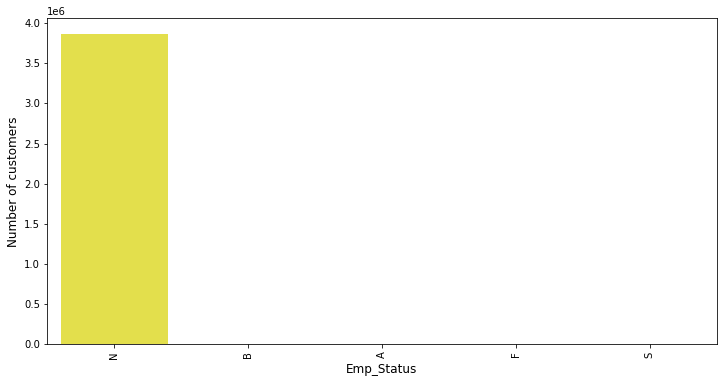


Number of unique values in  Cust_Ctry  :  99


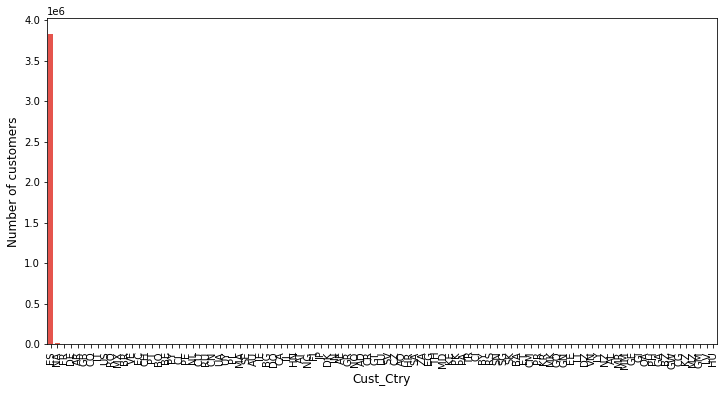


Number of unique values in  Cust_Sex  :  3


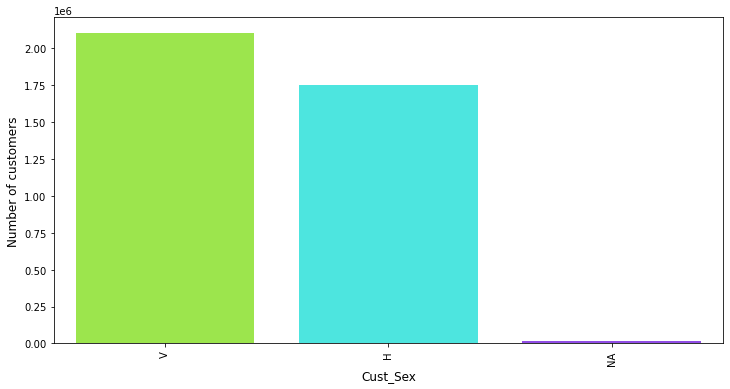


Number of unique values in  Is_New_Cust  :  3


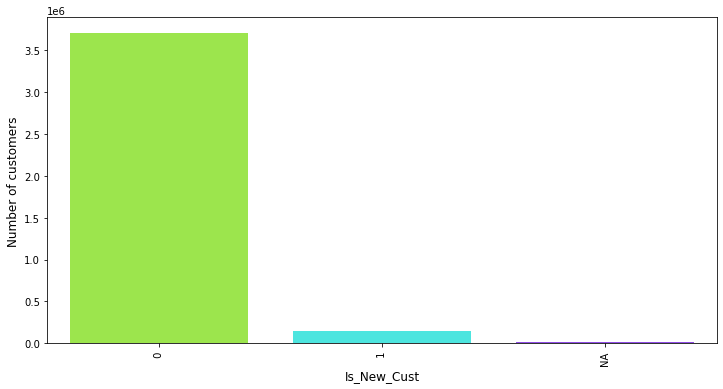


Number of unique values in  Relship_Status  :  3


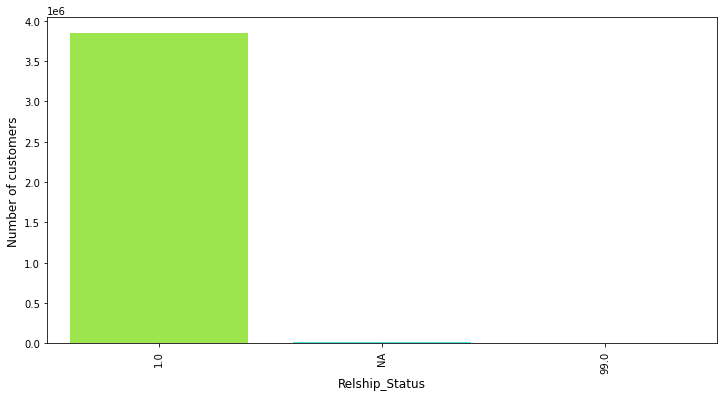


Number of unique values in  Cust_Type_Mth_Beg  :  5


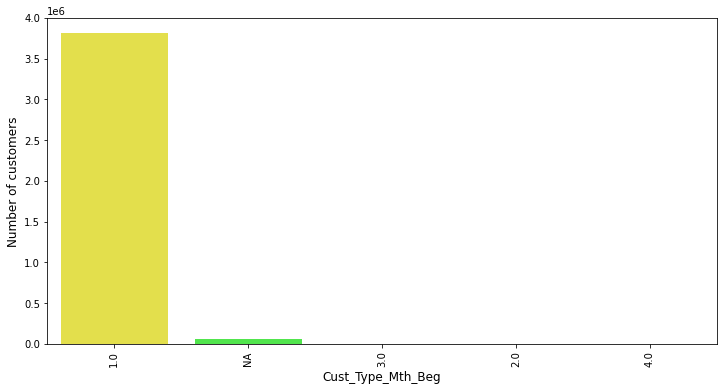


Number of unique values in  Cust_Relship_Type_Mth_Beg  :  6


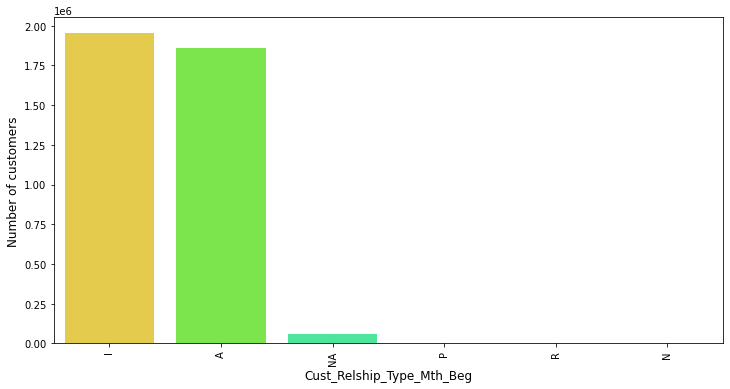


Number of unique values in  Residence_Ctry  :  3


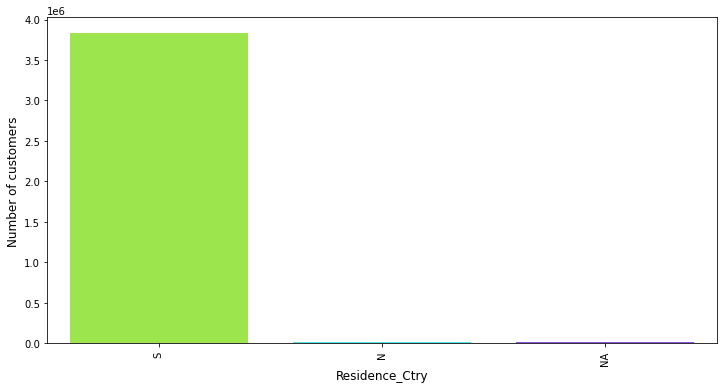


Number of unique values in  Is_Foreigner  :  3


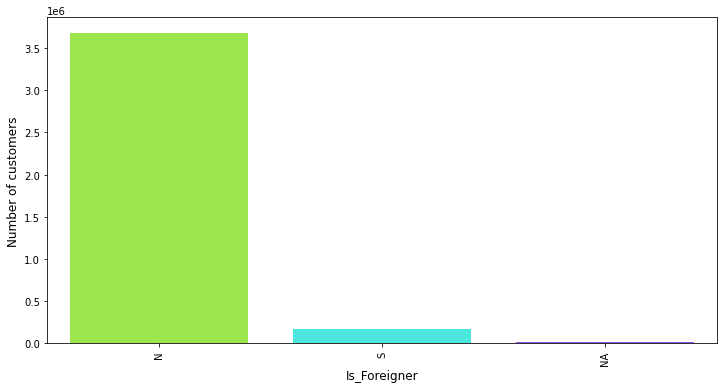


Number of unique values in  Join_Channel  :  157


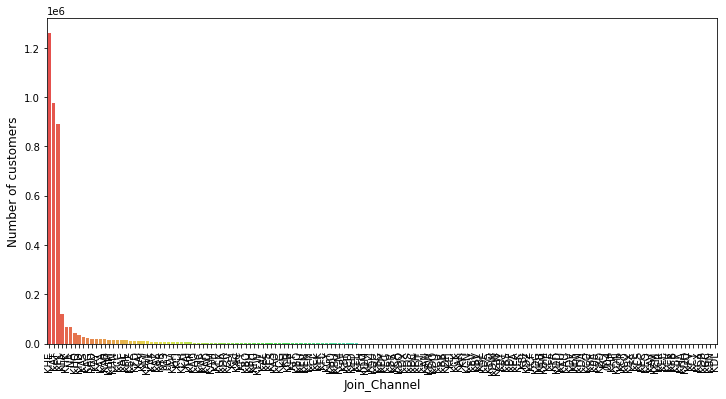


Number of unique values in  Deceased_Flg  :  3


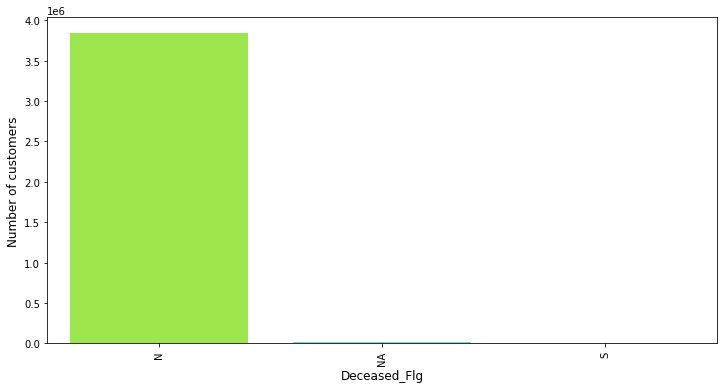


Number of unique values in  Address_Type  :  2


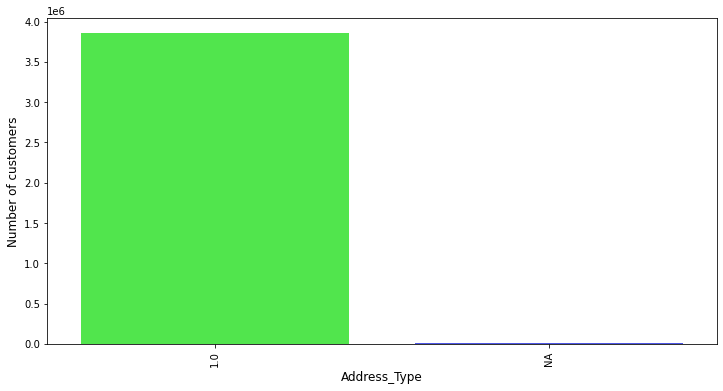


Number of unique values in  Cust_Province_Cd  :  53


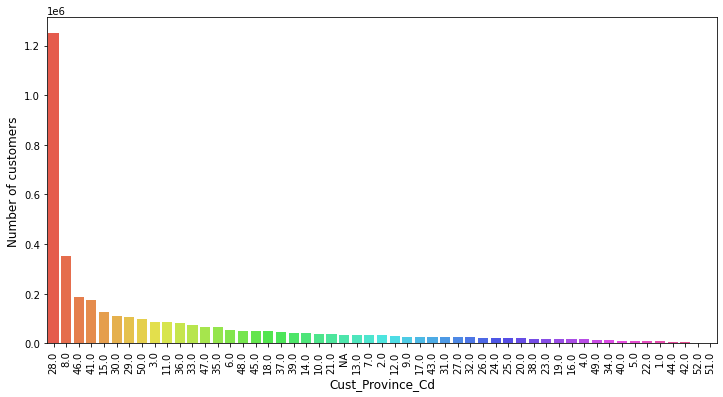


Number of unique values in  Cust_Province_Name  :  53


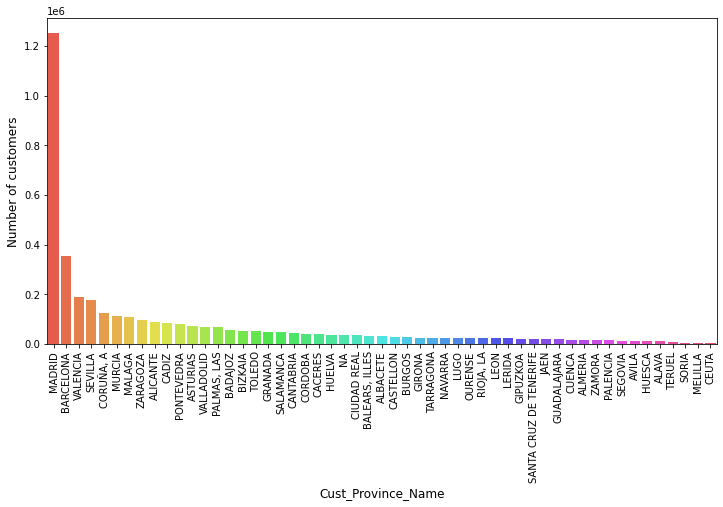


Number of unique values in  Cust_Active_Status  :  3


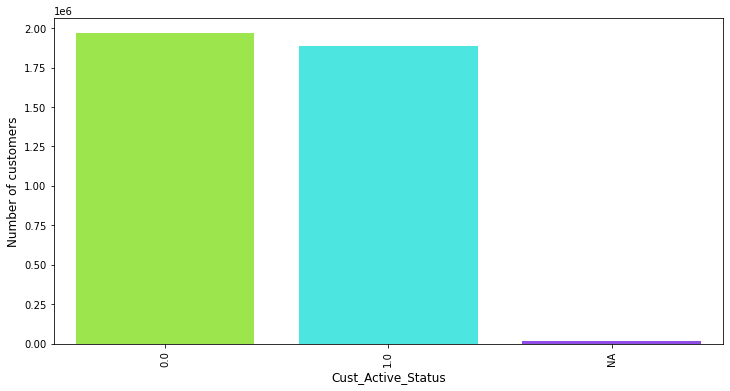


Number of unique values in  Cust_Segment  :  4


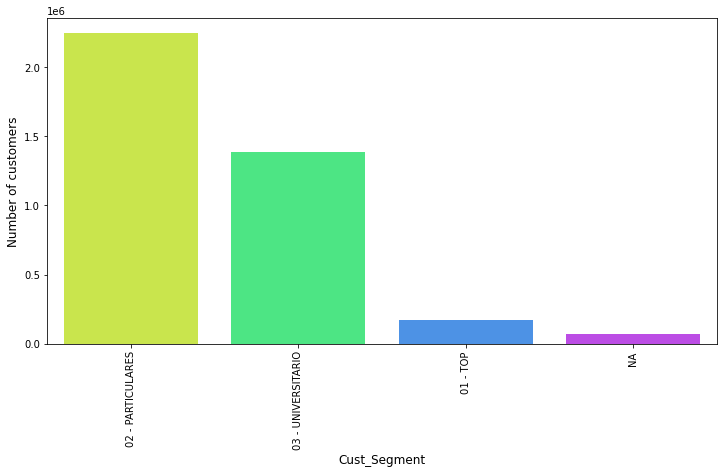

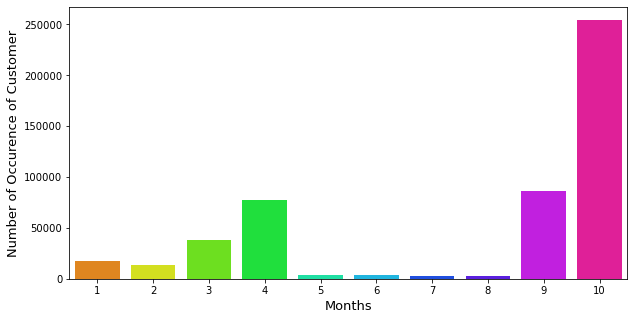

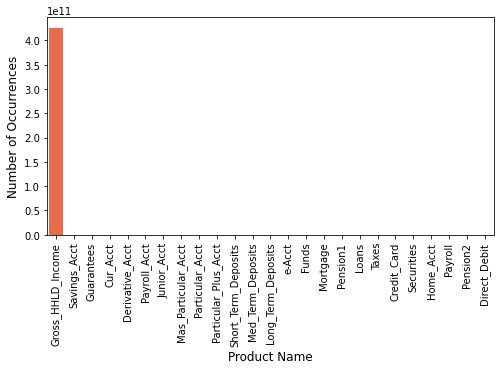

Number of unique values in Employee Status :  5


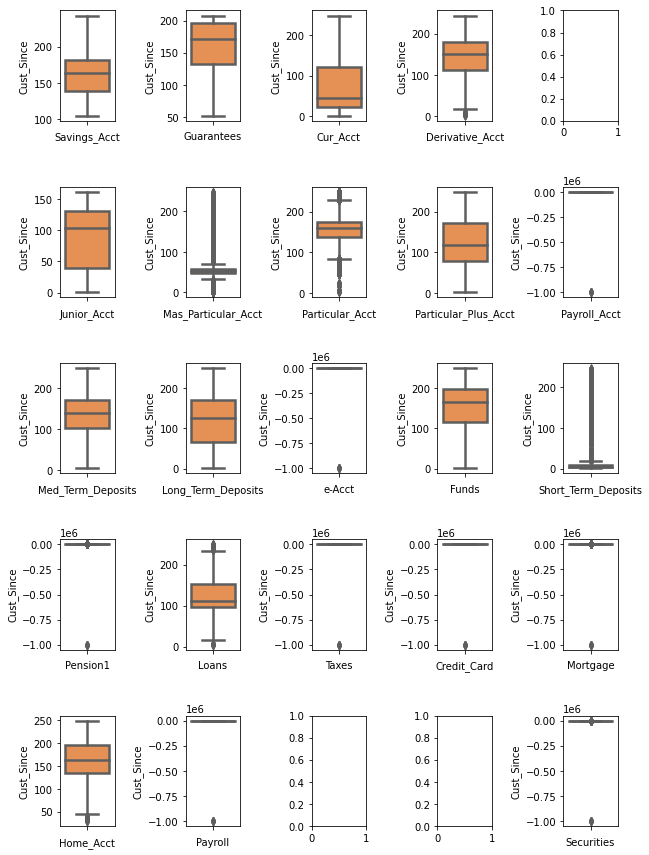

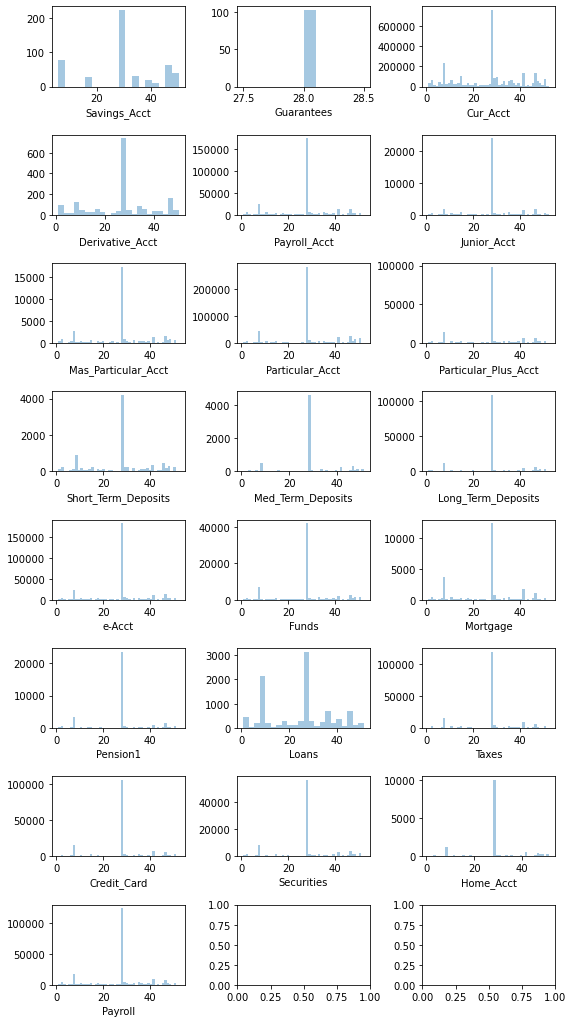

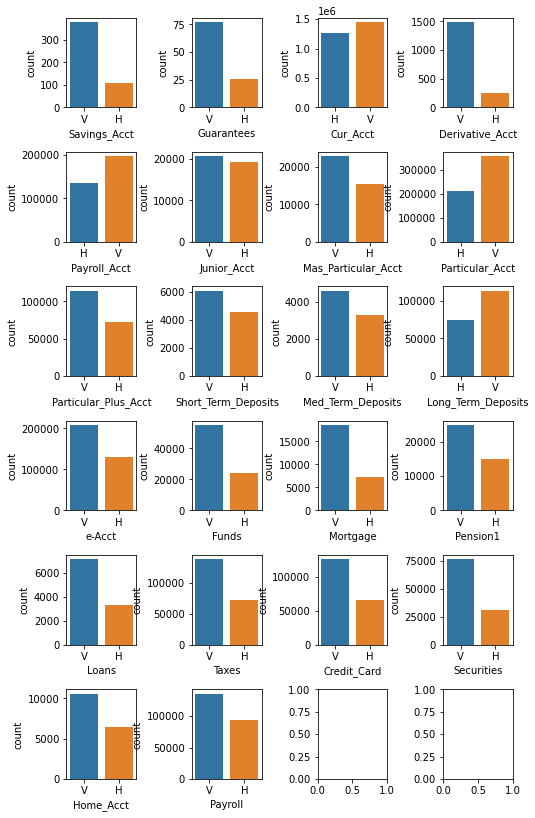

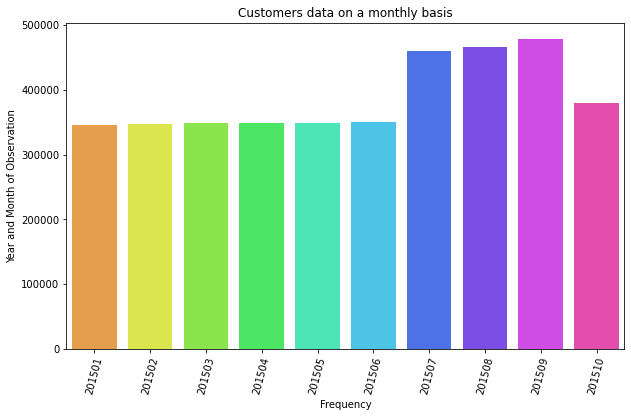

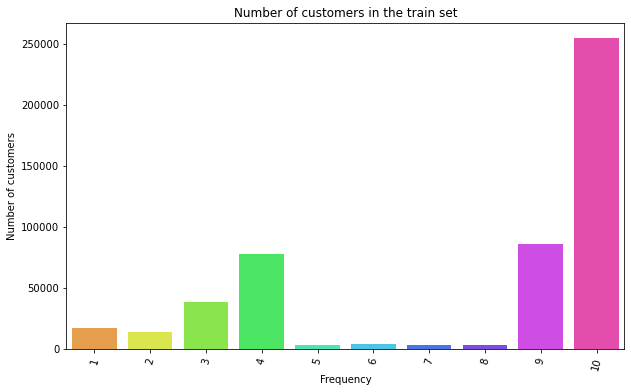

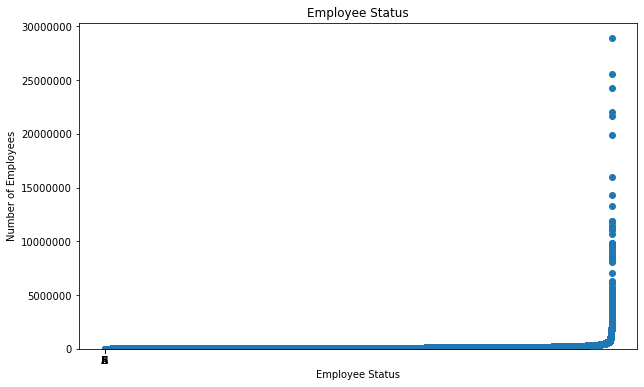

Number of unique values in Employee Status :  5
Number of unique values in Cusotmer Country :  98
Number of unique values in Customer Age :  83
Most aged Customer is :  100
Junior most customer is :  18
Average age of customer is :  40.25152319865259
Number of unique months in Customer's Joined Date :  12
Most Customer's joined in the month of  :  10.0
Few Customer's joined in the month of :  5.0
Minimum value of Join Date :  199501.0
Maximum value of Join Date :  201510.0


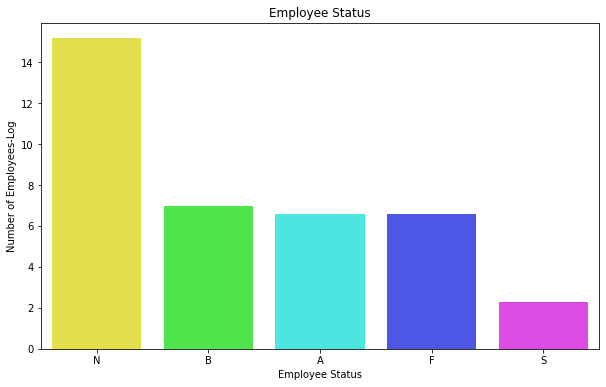

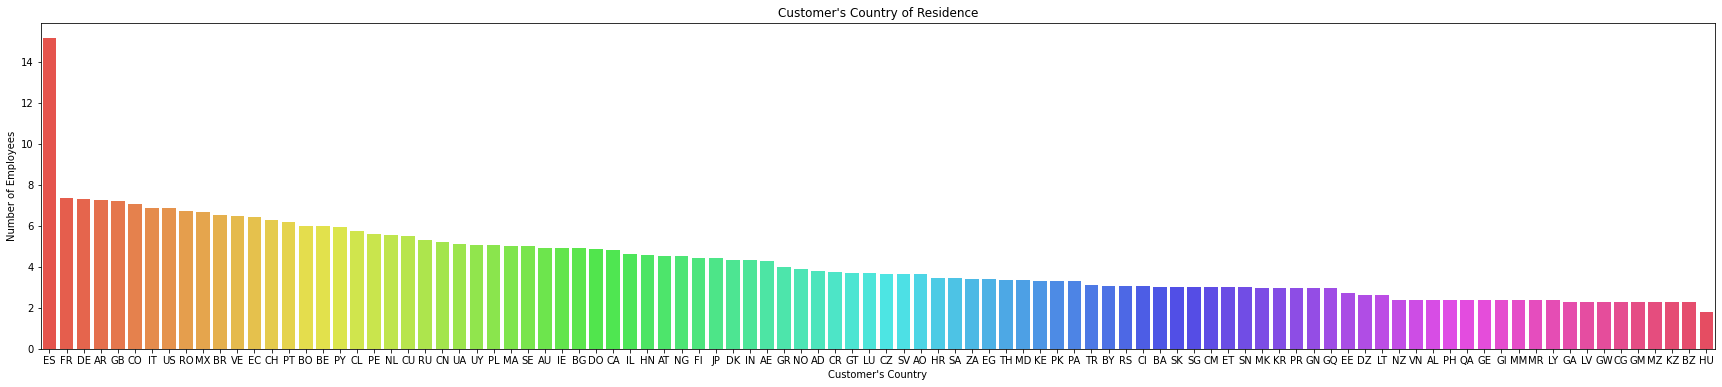

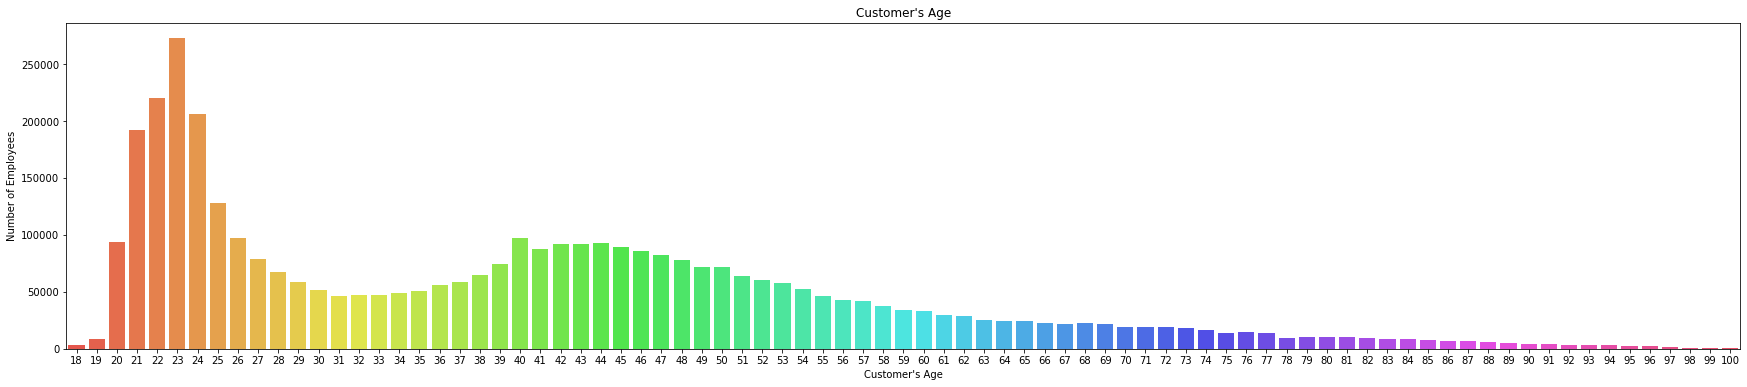

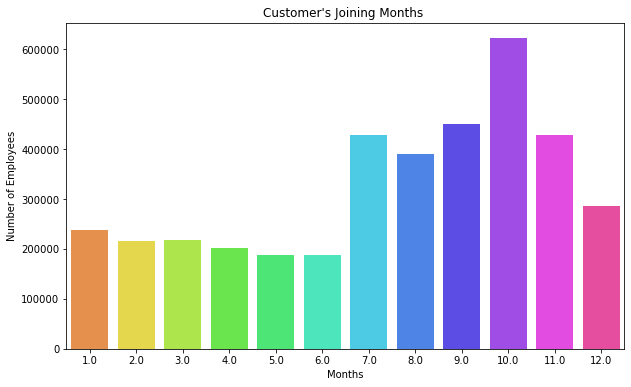

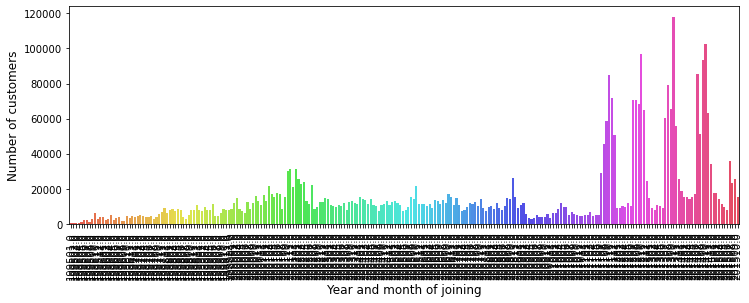

Number of unique values in Customer_Since :  250
Most number of people have been a customer for the past 12.0 months
Number of unique values in Channels used to join :  149
Number of data points in Channel KHE : 1259945 ( 32.547 %)
Number of data points in Channel KAT : 974235 ( 25.167 %)
Number of data points in Channel KFC : 889417 ( 22.976 %)
Number of data points in Channel KFA : 121501 ( 3.139 %)
Number of data points in Channel KHK : 67951 ( 1.755 %)
Number of data points in Channel KHQ : 42614 ( 1.101 %)
Number of data points in Channel KHD : 35438 ( 0.915 %)
Number of data points in Channel KAS : 25955 ( 0.67 %)
Number of data points in Channel KAG : 21738 ( 0.562 %)
Number of data points in Channel RED : 20488 ( 0.529 %)
Number of data points in Channel KAY : 19849 ( 0.513 %)
Number of data points in Channel KAA : 18582 ( 0.48 %)
Number of data points in Channel KAB : 18277 ( 0.472 %)
Number of data points in Channel KHM : 15735 ( 0.406 %)
Number of data points in Channel KHN 

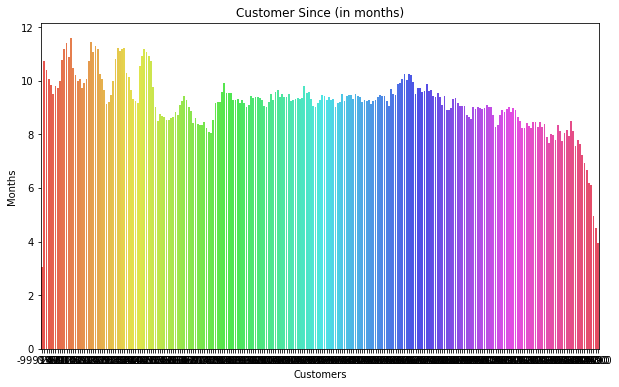

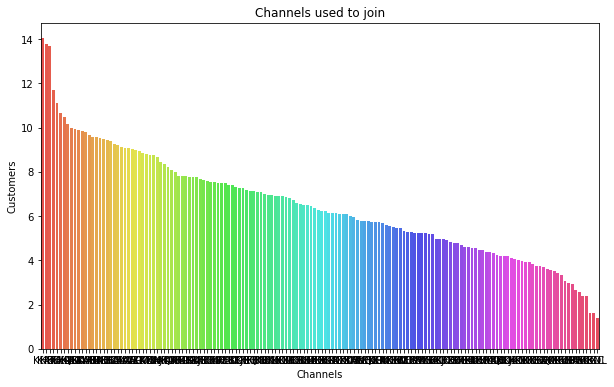

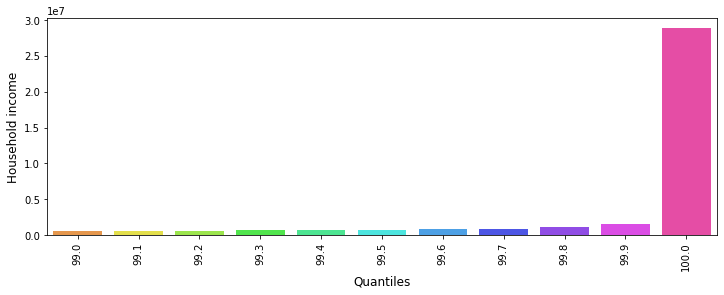

In [17]:
# EDA & Visualization
color = sns.color_palette()
viss = Visualizatin(df_train_sample)

viss.df_check_info()
viss.calculate_null()
viss.popular_product()
viss.popularity_of_products_by_sex_exclude()
#can remove
viss.age_distribution()
#can remove
viss.age_distribution_pp()
viss.visual_category()
viss.vis_customer()
viss.product_vis()
viss.distribution_product_since()
viss.distribution_product_province()
viss.distribution_product_sex()
viss.customers_data_monthly()
viss.number_customers_train()
viss.number_employees()
viss.gross_income()
viss.number_employees_log()
viss.customer_residence()
viss.customer_age()
viss.join_month()
viss.new_customers_join()
viss.customer_Since()
viss.channels_used_to_join()
viss.household_distribution()

In [18]:
# DATA PREPROCESSING AND TRAINING
category_features = ['ind_empleado','sexo','ind_nuevo','indrel','indrel_1mes','tiprel_1mes','indresi','indext','indfall','tipodom','ind_actividad_cliente','segmento','pais_residencia','canal_entrada']
renta_dict = {'ALBACETE': 76895,  'ALICANTE': 60562,  'ALMERIA': 77815,  'ASTURIAS': 83995,  'AVILA': 78525,  'BADAJOZ': 60155,  'BALEARS, ILLES': 114223,  'BARCELONA': 135149,  'BURGOS': 87410, 'NAVARRA' : 101850,
'CACERES': 78691,  'CADIZ': 75397,  'CANTABRIA': 87142,  'CASTELLON': 70359,  'CEUTA': 333283, 'CIUDAD REAL': 61962,  'CORDOBA': 63260,  'CORUÑA, A': 103567,  'CUENCA': 70751,  'GIRONA': 100208,  'GRANADA': 80489,
'GUADALAJARA': 100635,  'HUELVA': 75534,  'HUESCA': 80324,  'JAEN': 67016,  'LEON': 76339,  'LERIDA': 59191,  'LUGO': 68219,  'MADRID': 141381,  'MALAGA': 89534,  'MELILLA': 116469, 'GIPUZKOA': 101850,
'MURCIA': 68713,  'OURENSE': 78776,  'PALENCIA': 90843,  'PALMAS, LAS': 78168,  'PONTEVEDRA': 94328,  'RIOJA, LA': 91545,  'SALAMANCA': 88738,  'SANTA CRUZ DE TENERIFE': 83383, 'ALAVA': 101850, 'BIZKAIA' : 101850,
'SEGOVIA': 81287,  'SEVILLA': 94814,  'SORIA': 71615,'CORUÃ‘A, A':103567,  'TARRAGONA': 81330,  'TERUEL': 64053,  'TOLEDO': 65242,  'UNKNOWN': 103689,  'VALENCIA': 73463,  'VALLADOLID': 92032,  'ZAMORA': 73727,  'ZARAGOZA': 98827}

products = ['ind_ahor_fin_ult1','ind_aval_fin_ult1','ind_cco_fin_ult1','ind_cder_fin_ult1','ind_cno_fin_ult1','ind_ctju_fin_ult1','ind_ctma_fin_ult1','ind_ctop_fin_ult1','ind_ctpp_fin_ult1','ind_deco_fin_ult1','ind_deme_fin_ult1','ind_dela_fin_ult1','ind_ecue_fin_ult1','ind_fond_fin_ult1','ind_hip_fin_ult1','ind_plan_fin_ult1','ind_pres_fin_ult1','ind_reca_fin_ult1','ind_tjcr_fin_ult1','ind_valo_fin_ult1','ind_viv_fin_ult1','ind_nomina_ult1','ind_nom_pens_ult1','ind_recibo_ult1']
products = products[2:]

# Get boolean value of each product column
def Process_products(row):
    tlist = []
    for col in products:
        if row[col].strip() in ['', 'NA']:
            target = 0
        else:
            target = int(float(row[col]))
        tlist.append(target)
    return tlist

# Get index of Customers
def Process_Index(row, col):
    val = row[col]#.strip()
    if pd.isna(val):
      val="0"
    try:
      ind = objs[columns_name.index(col)].transform(val)
    except:
      val="0"
    ind = objs[columns_name.index(col)].transform([val])
    return ind

# Process missing value of Age by calculating mean age of all Customer and get as a numerical feature for training data
def Process_Age(row):
    mean_age = 40.
    min_age = 18.
    max_age = 100.
    range_age = max_age - min_age
    age = row['age'].strip()
    if age == 'NA' or age == '':
        age = mean_age
    else:
        age = float(age)
        if age < min_age:
            age = min_age
        elif age > max_age:
            age = max_age
    return round( (age - min_age) / range_age, 4)

# Process missing value of "Seniority" and get as a numerical feature for training data
def Process_Seniority(row):
    min_value = 0.
    max_value = 256.
    range_value = max_value - min_value
    missing_value = 0.
    cust_seniority = row['antiguedad'].strip()
    if cust_seniority ==  'NA' or cust_seniority == '':
        cust_seniority = missing_value
    else:
        cust_seniority = float(cust_seniority)
        if cust_seniority < min_value:
            cust_seniority = min_value
        elif cust_seniority > max_value:
            cust_seniority = max_value
    return round((cust_seniority-min_value) / range_value, 4)


# Process missing value of "Renta" and get as a numerical feature for training data
def Process_Renta(row):
    min_value = 0.
    max_value = 1500000.
    range_value = max_value - min_value
    rent = row['renta'].strip()
    if rent == 'NA' or rent == '':
        if row['nomprov'] ==  'NA' or row['nomprov'] == '':
            rent = float(renta_dict['UNKNOWN'])
        else:
            rent = float(renta_dict[row['nomprov']])
    else:
        rent = float(rent)
        if rent < min_value:
            rent = min_value
        elif rent > max_value:
            rent = max_value
    return round((rent-min_value) / range_value, 6)

def getMonth(row):
    return int(row['fecha_dato'].split('-')[1])

# This function process all data at the same time. And return lists of feature and label before we put into model.
def DataPreprocessing(in_file_name, cust_dict, lag_cust_dict1, lag_cust_dict2, lag_cust_dict3, lag_cust_dict4):
    x_vars_list = []
    y_vars_list = []
    for row in csv.DictReader(in_file_name):
        if row['fecha_dato'] not in ['2015-01-28', '2015-02-28', '2015-03-28', '2015-04-28', '2015-05-28', '2015-06-28', '2016-01-28', '2016-02-28', '2016-03-28', '2016-04-28', '2016-05-28', '2016-06-28']:
            continue
        cust_id = int(row['ncodpers'])
        
        if (row['fecha_dato'] in ['2015-01-28', '2016-01-28'] ):
            target_list = Process_products(row)
            lag_cust_dict1[cust_id] =  target_list[:]
            continue
            
        if (row['fecha_dato'] in ['2015-02-28', '2016-02-28'] ):
            target_list = Process_products(row)
            lag_cust_dict2[cust_id] =  target_list[:]
            continue
            
        if (row['fecha_dato'] in ['2015-03-28', '2016-03-28'] ):
            target_list = Process_products(row)
            lag_cust_dict3[cust_id] =  target_list[:]
            continue
            
        if (row['fecha_dato'] in ['2015-04-28', '2016-04-28'] ):
            target_list = Process_products(row)
            lag_cust_dict4[cust_id] =  target_list[:]
            continue
        
        if (row['fecha_dato'] in ['2015-05-28', '2016-05-28'] ):
            target_list = Process_products(row)
            cust_dict[cust_id] =  target_list[:]
            continue
        
        x_vars = []
        for col in category_features:
            x_vars.append( Process_Index(row, col) )
        sex = Process_Index(row, 'sexo')
        age = Process_Age(row)
        x_vars.append(age)
        x_vars.append( getMonth(row))
        x_vars.append(Process_Seniority(row))
        income = Process_Renta(row)
        x_vars.append(income)
        if row['fecha_dato'] == '2016-06-28':
            prev_target_list = cust_dict.get(cust_id, [0]*22)
            lag_target_list1 = lag_cust_dict1.get(cust_id, [0]*22)
            lag_target_list2 = lag_cust_dict2.get(cust_id, [0]*22)
            lag_target_list3 = lag_cust_dict3.get(cust_id, [0]*22)
            lag_target_list4 = lag_cust_dict4.get(cust_id, [0]*22)
            x_vars_list.append(x_vars + prev_target_list + lag_target_list1+lag_target_list2 + lag_target_list3 + lag_target_list4)
        elif row['fecha_dato'] == '2015-06-28':
            prev_target_list = cust_dict.get(cust_id, [0]*22)
            lag_target_list1 = lag_cust_dict1.get(cust_id, [0]*22)
            lag_target_list2 = lag_cust_dict2.get(cust_id, [0]*22)
            lag_target_list3 = lag_cust_dict3.get(cust_id, [0]*22)
            lag_target_list4 = lag_cust_dict4.get(cust_id, [0]*22)
            target_list = Process_products(row)
            new_products = [max(x1 - x2,0) for (x1, x2) in zip(target_list, prev_target_list)]
            if sum(new_products) > 0:
                for ind, prod in enumerate(new_products):
                    if prod>0:
                        assert len(prev_target_list) == 22
                        x_vars_list.append(x_vars+prev_target_list+lag_target_list1+lag_target_list2+lag_target_list3+lag_target_list4)
                        y_vars_list.append(ind)
     
    return x_vars_list, y_vars_list, cust_dict, lag_cust_dict1, lag_cust_dict2, lag_cust_dict3, lag_cust_dict4

# Set parameters and run XGB model  
def runXGB(train_X, train_y, seed_val=27):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.03
    param['max_depth'] = 10
    param['silent'] = 0
    param['num_class'] = 22
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = 12
    param['subsample'] = 0.8
    param['colsample_bytree'] = 0.8
    param['seed'] = seed_val
    num_rounds = 80
# Setting Grid Search Parameter    
    parameter = {'learning_rate': [0.05, 0.1, 0.3],'max_depth': [6,8,10,12,20],'min_child_weight': [6,10,14,18],'colsample_bytree':[.5,.8,.9],'subsample':[.5,.8,.9]}
    grid = GridSearchCV(xgb.XGBClassifier(objective='multi:softprob',num_class=22,num_rounds = 50,eval_metric = "mlogloss"), param_grid = parameter, cv= 5, scoring='balanced_accuracy')
    grid.fit(train_X,train_y)
    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)
    model = xgb.train(plst, xgtrain, num_rounds)
    print("Best score: %0.3f" % grid.best_score_)
    print("Best parameters:", grid.best_params_)
    return model

# Run main section and functions
if __name__ == "__main__":
  start_time = datetime.datetime.now()
  data_path = "gdrive/My Drive/data/santader/"
  train_file =  open( "train_ver2.csv")
  print('Starting file processing')
  x_vars_list, y_vars_list, cust_dict, lag_cust_dict1, lag_cust_dict2, lag_cust_dict3, lag_cust_dict4 = DataPreprocessing(train_file, {}, {}, {}, {}, {})
  print('Finished file processing')
  train_X = np.array(x_vars_list)
  train_y = np.array(y_vars_list)
  del x_vars_list, y_vars_list
  train_file.close()
  print(train_X.shape, train_y.shape)
  print(datetime.datetime.now()-start_time)
  test_file = open( "test_ver2.csv")
  x_vars_list, y_vars_list, cust_dict, _, _, _, _ = DataPreprocessing(test_file, cust_dict, lag_cust_dict1, lag_cust_dict2, lag_cust_dict3, lag_cust_dict4)
  test_X = np.array(x_vars_list)
  del x_vars_list
  test_file.close()
  print(test_X.shape)
  print(datetime.datetime.now()-start_time)
  print("Building model..")
  model = runXGB(train_X, train_y, seed_val=0)
  del train_X, train_y
  print("Predicting..")
  xgtest = xgb.DMatrix(test_X)
  preds = model.predict(xgtest)
  del test_X, xgtest
  print(datetime.datetime.now()-start_time)
  print(preds[0:5,:])
  print("Getting the top products..")
  test_id = np.array(pd.read_csv( "test_ver2.csv", usecols=['ncodpers'])['ncodpers'])
  new_products = []
  for i, idx in enumerate(test_id):
    new_products.append([max(x1 - x2,0) for (x1, x2) in zip(preds[i,:], cust_dict[idx])])
  products = np.array(products)
  preds = np.argsort(np.array(new_products), axis=1)
  preds = np.fliplr(preds)[:,:7]
  final_preds = [" ".join(list(products[pred])) for pred in preds]
  out_df = pd.DataFrame({'ncodpers':test_id, 'added_products':final_preds})
  out_df.to_csv('new_result.csv', index=False)
  print(datetime.datetime.now()-start_time)

Starting file processing
Finished file processing
(45679, 128) (45679,)
0:11:11.436534
(929615, 128)
0:23:14.300047
Building model..
[20:39:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Predicting..
0:23:59.228442
[[0.01564654 0.01368737 0.02368941 0.01350557 0.01400274 0.02960643
  0.0150833  0.01375657 0.01360088 0.03495035 0.02865675 0.02346352
  0.01354009 0.01376734 0.01555237 0.09988914 0.03010132 0.01529397
  0.01350128 0.03635797 0.03961391 0.48273313]
 [0.01790381 0.01536113 0.06125217 0.015238   0.01592517 0.01533154
  0.0153301  0.01538236 0.01534553 0.02460522 0.03184487 0.016878
  0.01527694 0.01554655 0.01530959 0.06090182 0.04671076 0.0167635
 

## Summary of Results

 The results are evaluated according to the Mean Average Precision @ 7 (MAP@7).
It's required to recommend the top 7 products to each customer. The scoring was evaluated using mean average precision at 7 (MAP@7).

### In this solution, model is trained on 5 months of historical ownership features. Grid Search technique is applied.

**Final Result: 0.03016 on Private Score** 